In [1]:
import ap1
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from sklearn.preprocessing import MinMaxScaler

import IPython

import os

import stepwindow
import prediction

from prediction import trainModel, performance, predictModel, r_squared

In [2]:
import importlib
importlib.reload(ap1)

importlib.reload(stepwindow)

importlib.reload(prediction)
from prediction import trainModel, performance, predictModel, r_squared

In [3]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 100)

## Load Data

In [4]:
path = '/Users/kritkorns/Mike/Jacob/AdvancedProject1/01_Lab'
years = range(2012, 2021)
#years = range(2018, 2019)
df_freqs = {}

for year in years:
    file = '{}/dataset/Germany/{}.csv'.format(path,year)
    df_temp = pd.read_csv(file, parse_dates=['Datetime'])
    df_freqs[year] = df_temp


In [5]:
df_freqs_all = pd.concat(df_freqs)
df_freqs_all = df_freqs_all.set_index('Datetime')
df_freqs_all

Frequency  year  month  day  hour  minute  second
Datetime                                                              
2012-01-01 00:00:00        NaN  2012      1    1     0       0       0
2012-01-01 00:00:01        NaN  2012      1    1     0       0       1
2012-01-01 00:00:02        NaN  2012      1    1     0       0       2
2012-01-01 00:00:03        NaN  2012      1    1     0       0       3
2012-01-01 00:00:04        NaN  2012      1    1     0       0       4
...                        ...   ...    ...  ...   ...     ...     ...
2020-09-30 23:59:55       20.0  2020      9   30    23      59      55
2020-09-30 23:59:56       22.0  2020      9   30    23      59      56
2020-09-30 23:59:57       24.0  2020      9   30    23      59      57
2020-09-30 23:59:58       26.0  2020      9   30    23      59      58
2020-09-30 23:59:59       27.0  2020      9   30    23      59      59

[276134400 rows x 7 columns]

## Statistical Modeling

In [6]:
def groupData(df, by):
    """
        df :
         - DataFrame
        by : 
         - 'M' -> Month
         - 'D' -> Day
         - 'H' -> Hour
         - 'T' -> Minute
    """
    
    df_temp = df.copy()
    df_temp.index = df_temp.index.to_period(by)
    df_temp = df_temp.groupby(df_temp.index).mean()
    df_temp.index = df_temp.index.to_timestamp()
    
    return df_temp
    

In [7]:
def splitData(df, train_size=0.7, val_size=0.2):
    # Split Data
    #train_size = sample/len(df)
    #df_train, df_test = train_test_split(df, train_size=train_size, shuffle=False)
    
    n = len(df)
    df_train = df[0:int(n*train_size)]
    df_val = df[int(n*train_size):int(n*(train_size+val_size))]
    df_test = df[int(n*(train_size+val_size)):]
    
    return df_train, df_val, df_test

def fillNa(df, show=True):
    if show == True:
        print('Number of missing rows in dataset: \n{}\n'.format(df.isna().sum()))
    
    # Dealing with null: Fill NA with time interpolate
    if (df.isna().sum()) != 0:
        df = df.interpolate(method ='time')
        if show == True:
            print('Fill null with interpolate...')
            print('Number of missing rows in dataset: \n{}\n'.format(df.isna().sum()))
    # Dealing with null: Fill NA with mean value
        if (df.isna().sum()) != 0:
            df = df.fillna(df.mean())
            if show == True:
                print('Fill null with mean value...')
                print('Number of missing rows in dataset: \n{}\n'.format(df.isna().sum()))
    return df

def normalization(df, show=True, name="Frequency"):
    # Normalization
    if show == True:
        print('Regular Dataset')
        display(df.head())
    
    scaler = MinMaxScaler()
    a_array = np.array(df).reshape(-1, 1)
    a_array = scaler.fit_transform(a_array)
    df_result = pd.Series(a_array.reshape(-1), index=df.index, name=name)
    #df = (df-df.min())/(df.max()-df.min())
    
    if show == True:
        print('Normalised Dataset')
        display(df_result.head())
    
    return df_result, scaler

def preProcessing(df, show=True):
    # Dealing with null
    df = fillNa(df, show)
    
    # Normalization
    df, scaler = normalization(df, show)
    
    return df

## Plot trend, Sesonal, Residual in month interval

In [8]:
df_plot = fillNa(df_freqs_all['Frequency'])
df_plot = groupData(df_plot, by='M')
df_plot

Number of missing rows in dataset: 
20839144

Fill null with interpolate...
Number of missing rows in dataset: 
2678400

Fill null with mean value...
Number of missing rows in dataset: 
0



Datetime
2012-01-01     0.346588
2012-02-01    -0.189442
2012-03-01    -0.659523
2012-04-01    -0.651384
2012-05-01    -1.980445
2012-06-01    -1.564834
2012-07-01    -1.412304
2012-08-01    -1.077548
2012-09-01    -2.072080
2012-10-01    -0.039018
2012-11-01    -1.770375
2012-12-01    -1.320751
2013-01-01    -0.077416
2013-02-01    -0.585049
2013-03-01    -1.371672
2013-04-01    -2.027125
2013-05-01    -4.085460
2013-06-01     1.673424
2013-07-01    -2.617542
2013-08-01    -1.841195
2013-09-01    -5.421296
2013-10-01    -0.674662
2013-11-01    -0.608406
2013-12-01     0.508758
2014-01-01    -0.647041
2014-02-01    -0.436114
2014-03-01    -0.273701
2014-04-01     0.297809
2014-05-01    -0.519014
2014-06-01    -1.424805
2014-07-01    -0.718894
2014-08-01    -0.939671
2014-09-01     1.230612
2014-10-01     0.318289
2014-11-01    -0.532728
2014-12-01    -0.076078
2015-01-01    -0.047361
2015-02-01    -0.053576
2015-03-01     0.680804
2015-04-01     0.450948
2015-05-01    12.347288
2015-06

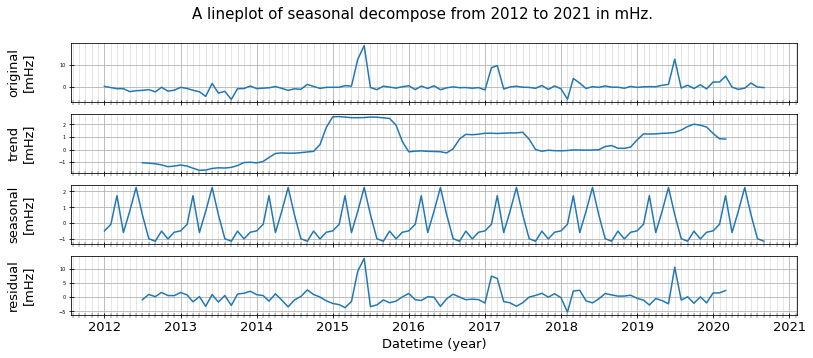

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

result = {}
decompose_result_mult = seasonal_decompose(df_plot, model="additive")
xaxis = df_plot.index

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

trend.index = xaxis
seasonal.index = xaxis
residual.index = xaxis

result['original'] = df_plot
result['trend'] = trend
result['seasonal'] = seasonal
result['residual'] =  residual

fig, axe = plt.subplots(len(result),1,figsize=(13,5), sharex=True)
fig.suptitle('A lineplot of seasonal decompose from 2012 to 2021 in mHz.', size=15)

for i, [key, value] in enumerate(result.items()):   
    axe[i].plot(value)
    axe[i].set_ylabel(f"{key}\n[mHz]", size=13)
    axe[i].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    axe[i].yaxis.set_label_coords(-0.05, 0.5)
    axe[i].tick_params(axis='x', which='major', width=0.8, length=5, direction='inout', rotation=0, labelsize=13)
    axe[i].tick_params(axis='y', which='major', width=0.8, length=5, direction='inout', rotation=0, labelsize=13)
    axe[i].tick_params(axis='x', which='minor', width=0.4, length=5, direction='inout', rotation=0, labelsize=13)
    axe[i].tick_params(axis='y', which='minor', width=0.4, length=5, direction='inout', rotation=0, labelsize=13)
    axe[i].grid(which='major', alpha=1)
    axe[i].grid(which='minor', alpha=0.4)
axe[i].set_xlabel("Datetime (year)", size=13)
plt.show()


## Month aggregation data in each year

In [8]:
years = range(2012, 2021)
for year in years:
    df_freqs[year] = groupData(df_freqs[year].set_index('Datetime')['Frequency'], by='H')

## Outliners

Let's find the outliner. We will use data without outliner to train the model because the outiners will affect the accuracy when we do normalization.

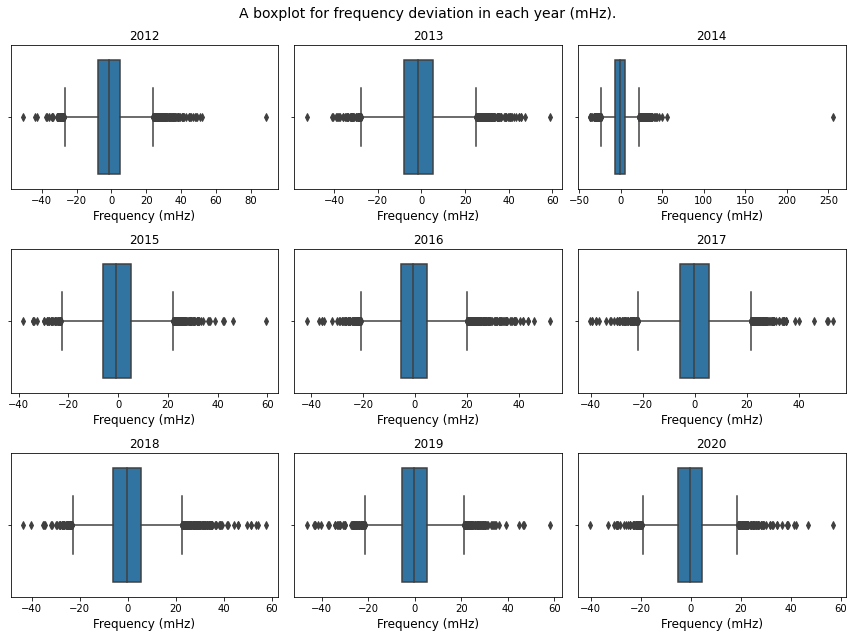

In [9]:
row_num = 3
col_num = 3
years = np.array(range(2012, 2021))
years = years.reshape(row_num, col_num)
#print(years)

plt.rcParams["figure.autolayout"] = True

fig, axe = plt.subplots(row_num, col_num, figsize=(4*col_num,3*row_num))
fig.suptitle('A boxplot for frequency deviation in each year (mHz).', size=14)

for i, col in enumerate(years):
    for j, year in enumerate(col):
        df_temp = df_freqs[year].copy()
        sns.boxplot(x=df_temp, ax=axe[i][j])
        axe[i][j].set_title(f"{year:d}")
        axe[i][j].set_xlabel("Frequency (mHz)", size=12)


We will select the data between -55 and 55. Below is the illustration of boxplot after the outliners are deal with.

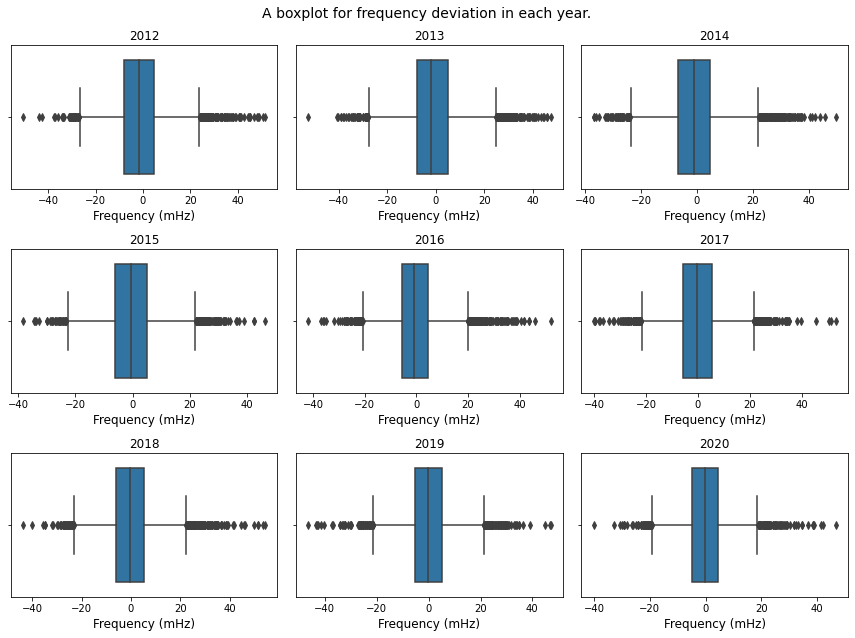

In [10]:
row_num = 3
col_num = 3
years = np.array(range(2012, 2021))
years = years.reshape(row_num, col_num)
#print(years)

fig, axe = plt.subplots(row_num, col_num, figsize=(4*col_num,3*row_num))
fig.suptitle('A boxplot for frequency deviation in each year.', size=14)
plt.rcParams["figure.autolayout"] = True

for i, col in enumerate(years):
    for j, year in enumerate(col):
        df_temp = df_freqs[year].copy()
        index = df_temp.loc[(df_temp>55) | (df_temp<-55)].index
        df_temp.loc[index] = None
        sns.boxplot(x=df_temp, ax=axe[i][j])
        axe[i][j].set_title(f"{year:d}")
        axe[i][j].set_xlabel("Frequency (mHz)", size=12)


## Pre-processing

### Select data

Select the data from year 2014 because it is the most complete dataset compare to other years.

In [11]:
df_selected = df_freqs[2014].copy()
display(df_selected)

Datetime
2014-01-01 00:00:00    -0.496105
2014-01-01 01:00:00    -7.084206
2014-01-01 02:00:00    10.860360
2014-01-01 03:00:00    16.250053
2014-01-01 04:00:00    12.296977
                         ...    
2014-12-31 19:00:00     2.662967
2014-12-31 20:00:00    23.929050
2014-12-31 21:00:00    18.354859
2014-12-31 22:00:00   -10.559148
2014-12-31 23:00:00    -2.306706
Freq: H, Name: Frequency, Length: 8760, dtype: float64

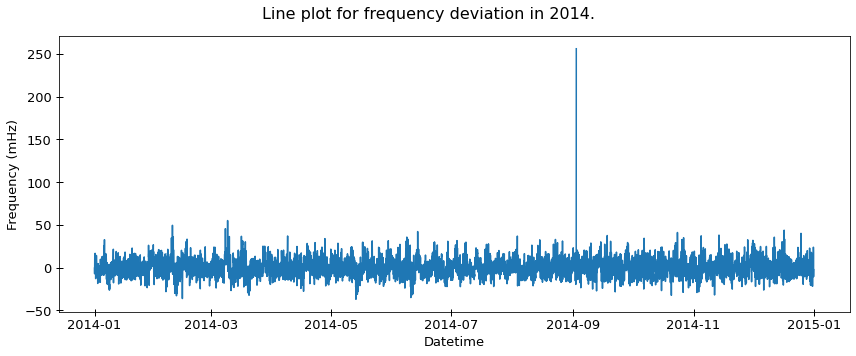

In [12]:
fig, axe = plt.subplots(figsize=(12,5))
fig.suptitle('Line plot for frequency deviation in 2014.', size=16)

axe.plot(df_selected)
axe.set_xlabel("Datetime", size=13)
axe.set_ylabel("Frequency (mHz)", size=13)
axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', width=1, length=7, direction='inout', rotation=0, labelsize=13)
plt.show()


### Outliner

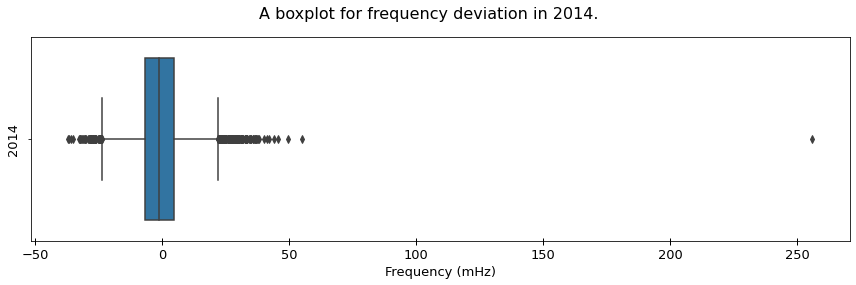

In [13]:
fig, axe = plt.subplots(figsize=(12,4))
fig.suptitle('A boxplot for frequency deviation in 2014.', size=16)

sns.boxplot(x=df_selected)
axe.set_xlabel("Frequency (mHz)", size=13)
axe.set_ylabel("2014", size=13)
axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=13)
plt.show()


Subtitute the outliners  with Null (values that are more than 55 and less than -55).

In [14]:
index = df_selected.loc[(df_selected>55) | (df_selected<-55)].index
df_selected.loc[index] = None
display(df_selected)

Datetime
2014-01-01 00:00:00    -0.496105
2014-01-01 01:00:00    -7.084206
2014-01-01 02:00:00    10.860360
2014-01-01 03:00:00    16.250053
2014-01-01 04:00:00    12.296977
                         ...    
2014-12-31 19:00:00     2.662967
2014-12-31 20:00:00    23.929050
2014-12-31 21:00:00    18.354859
2014-12-31 22:00:00   -10.559148
2014-12-31 23:00:00    -2.306706
Freq: H, Name: Frequency, Length: 8760, dtype: float64

The result after the outliner is dealt

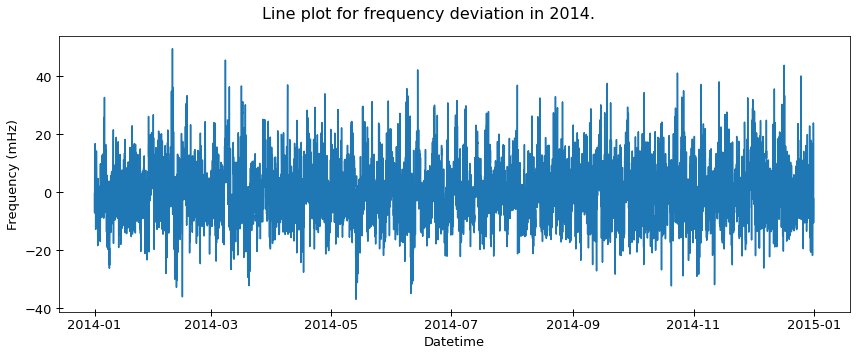

In [15]:
fig, axe = plt.subplots(figsize=(12,5))
fig.suptitle('Line plot for frequency deviation in 2014.', size=16)

axe.plot(df_selected)
axe.set_xlabel("Datetime", size=13)
axe.set_ylabel("Frequency (mHz)", size=13)
axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', width=1, length=7, direction='inout', rotation=0, labelsize=13)
plt.show()


### Split Data

We are going to split data into 3 datasets which are train, validation and test. The size of train, validation and test dataset compare to the whole dataset is 70%, 20% and 10% respectively.

In [16]:
num_features = 1

train_size = 0.7
val_size = 0.2

df_train, df_val, df_test = splitData(df_selected, train_size=0.7, val_size=0.2)

print('Number of entire dataset: {}'.format(len(df_selected)))
print('Number of Train dataset: {}'.format(len(df_train)))
print('Number of Validation dataset: {}'.format(len(df_val)))
print('Number of Test dataset: {}'.format(len(df_test)))

Number of entire dataset: 8760
Number of Train dataset: 6132
Number of Validation dataset: 1751
Number of Test dataset: 877


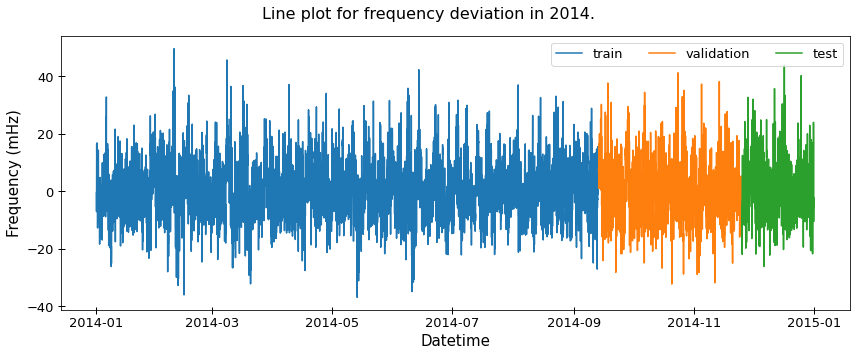

In [17]:
fig, axe = plt.subplots(figsize=(12,5))
fig.suptitle('Line plot for frequency deviation in 2014.', size=16)

axe.plot(df_train, label="train")
axe.plot(df_val, label="validation")
axe.plot(df_test, label="test")
axe.legend(ncol=3, loc="upper right", fontsize=13)
axe.set_xlabel("Datetime", size=15)
axe.set_ylabel("Frequency (mHz)", size=15)
#axe.tick_params(axis='both', which='major', labelsize=15)
axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', width=1, length=7, direction='inout', rotation=0, labelsize=13)
plt.show()

### Fill null and normalize data

Deal with NA :

    The null value will be filled with two steps. The first step is to fill NA with time interpolate and after that, the next step is to fill the rest of NA with mean values of the data.
    
Normalization:

    Then, the data in datasets will be normalize into the value range of 0 to 1 because in order to use in the equation of neural network, the input must be [0, 1].

In [18]:
# Fill null and normalize data
print('Fill null and normalization for train dataset.')
df_train = preProcessing(df_train)
print('Fill null and normalization for validation dataset.')
df_val = preProcessing(df_val)
print('Fill null and normalization for test dataset.')
df_test = preProcessing(df_test)


Fill null and normalization for train dataset.
Number of missing rows in dataset: 
13

Fill null with interpolate...
Number of missing rows in dataset: 
0

Regular Dataset


Datetime
2014-01-01 00:00:00    -0.496105
2014-01-01 01:00:00    -7.084206
2014-01-01 02:00:00    10.860360
2014-01-01 03:00:00    16.250053
2014-01-01 04:00:00    12.296977
Freq: H, Name: Frequency, dtype: float64

Normalised Dataset


Datetime
2014-01-01 00:00:00    0.421395
2014-01-01 01:00:00    0.345235
2014-01-01 02:00:00    0.552677
2014-01-01 03:00:00    0.614983
2014-01-01 04:00:00    0.569285
Freq: H, Name: Frequency, dtype: float64

Fill null and normalization for validation dataset.
Number of missing rows in dataset: 
16

Fill null with interpolate...
Number of missing rows in dataset: 
0

Regular Dataset


Datetime
2014-09-13 12:00:00    6.871857
2014-09-13 13:00:00    8.155197
2014-09-13 14:00:00    5.355632
2014-09-13 15:00:00    9.965469
2014-09-13 16:00:00    4.344047
Freq: H, Name: Frequency, dtype: float64

Normalised Dataset


Datetime
2014-09-13 12:00:00    0.533500
2014-09-13 13:00:00    0.550967
2014-09-13 14:00:00    0.512863
2014-09-13 15:00:00    0.575607
2014-09-13 16:00:00    0.499094
Freq: H, Name: Frequency, dtype: float64

Fill null and normalization for test dataset.
Number of missing rows in dataset: 
0

Regular Dataset


Datetime
2014-11-25 11:00:00   -13.329918
2014-11-25 12:00:00    -5.460556
2014-11-25 13:00:00    -8.772138
2014-11-25 14:00:00   -21.989024
2014-11-25 15:00:00   -10.668819
Freq: H, Name: Frequency, dtype: float64

Normalised Dataset


Datetime
2014-11-25 11:00:00    0.183359
2014-11-25 12:00:00    0.295793
2014-11-25 13:00:00    0.248479
2014-11-25 14:00:00    0.059641
2014-11-25 15:00:00    0.221380
Freq: H, Name: Frequency, dtype: float64

### The end product of pre-processing

### Histogram

In [19]:
def distributionValue(df):
    df_temp = df.copy()
    df_temp.dropna(inplace=True)
    a_dict = {}
    a_dict['mean'] = df_temp.mean()
    a_dict['median'] = df_temp.median()
    a_dict['std'] = df_temp.std()
    a_dict['skewness'] = skew(df_temp)
    a_dict['kurtosis'] = kurtosis(df_temp, fisher=False)

    return a_dict


def plotpdf(df, ax, bins=15, kde=True):
    df_temp = df.copy()
    def annotate(**kws):
        value = distributionValue(df_temp)
        bbox = dict(boxstyle="round,pad=0.3", alpha=0.3, fc="lightgrey", ec="grey", lw=1)
        annotate_value = (f"mean: {value['mean']:0.2f}\n"
                          f"std: {value['std']:0.2f}\n"
                          f"skew: {value['skewness']:0.2f}\n"
                          f"kurt: {value['kurtosis']:0.2f}")
        #ax = plt.gca()
        if value['skewness'] < 0:
            x_anotate = 0.05
        else:
            x_anotate = 0.7
        ax.annotate(annotate_value, xy=(x_anotate, .40), xycoords=ax.transAxes, fontsize=13, bbox=bbox)

    sns.histplot(df_temp, kde=kde, ax=ax, bins=bins)
    ax.tick_params(axis='x', rotation=15)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    plt.tight_layout()
    annotate()
    return ax


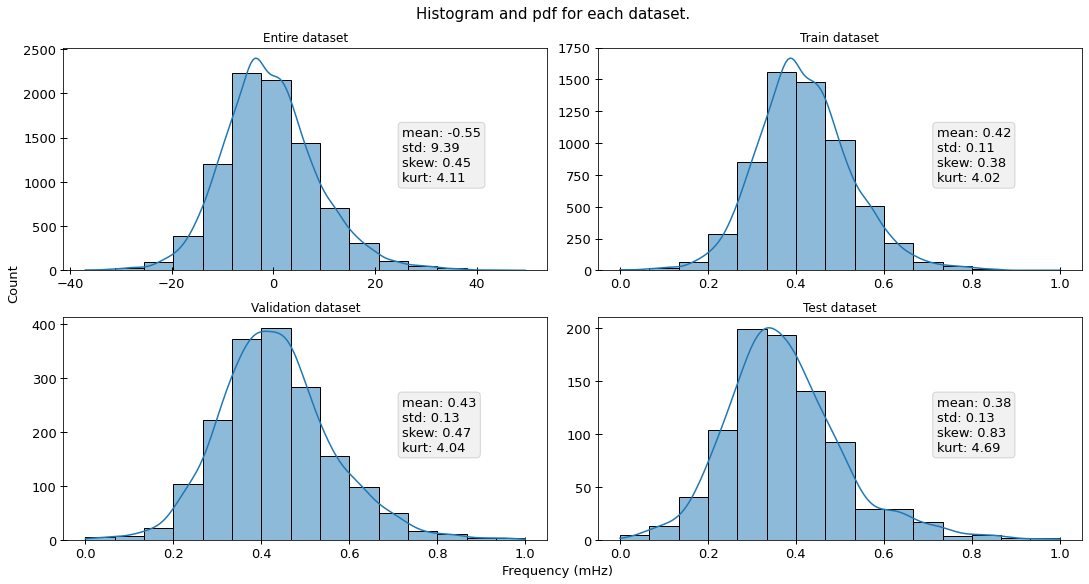

In [20]:
df_list = [{'Entire dataset':df_selected, 'Train dataset':df_train},
           {'Validation dataset':df_val, 'Test dataset':df_test}]

row_num = len(df_list)
col_num = len(df_list[0])
fig, axe = plt.subplots(row_num, col_num, figsize=(15, 8))
fig.suptitle('Histogram and pdf for each dataset.', size=15)

for i, df_dict in enumerate(df_list):
    for j, (key, value) in enumerate(df_list[i].items()):
        plotpdf(df_list[i][key], ax=axe[i][j])
        axe[i][j].set_title(key)
        axe[i][j].tick_params(axis='x', width=1, length=7, 
                              direction='inout', rotation=0, labelsize=13)
        axe[i][j].tick_params(axis='y', width=1, length=7, 
                              direction='inout', rotation=0, labelsize=13)

fig.text(0.505, -0.005, 'Frequency (mHz)', ha='center', size=13)
fig.text(-0.005, 0.500, 'Count', va='center', rotation='vertical', size=13)
plt.tight_layout(h_pad=1, w_pad=1)
plt.show()


### Line plot

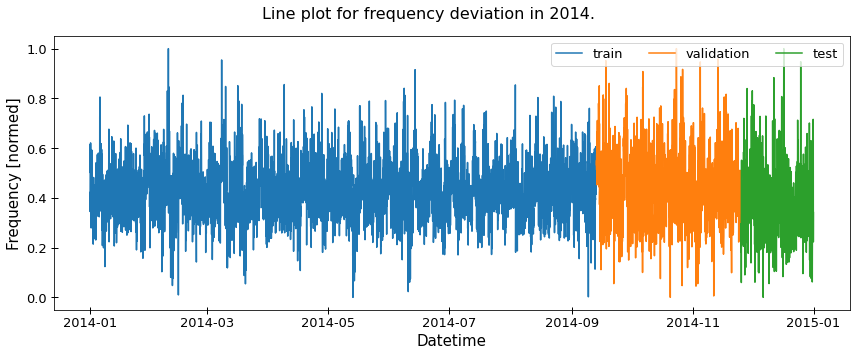

In [21]:
fig, axe = plt.subplots(figsize=(12,5))
fig.suptitle('Line plot for frequency deviation in 2014.', size=16)

axe.plot(df_train, label="train")
axe.plot(df_val, label="validation")
axe.plot(df_test, label="test")
axe.legend(ncol=3, loc="upper right", fontsize=13)
axe.set_xlabel("Datetime", size=15)
axe.set_ylabel("Frequency [normed]", size=15)
#axe.tick_params(axis='both', which='major', labelsize=15)
axe.tick_params(axis='x', width=1, length=7, direction='inout', rotation=0, labelsize=13)
axe.tick_params(axis='y', width=1, length=7, direction='inout', rotation=0, labelsize=13)
plt.show()

## Prediction

In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras import optimizers

from stepwindow import WindowGenerator

In [23]:
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)
df_test = pd.DataFrame(df_test)

### Create Models

In [24]:
# Caseline Model
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs


def linear(output_unit):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=output_unit),
        #tf.keras.layers.Reshape([output_unit, 1])
    ])
    return model


def lstm(hidden_lstmUnit, output_unit):
    model = tf.keras.Sequential([
        # unit means the size of the vector that is being outputted by every time-step LSTM cell.
        tf.keras.layers.LSTM(hidden_lstmUnit, activation='relu', return_sequences=True),
        tf.keras.layers.Flatten(),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=output_unit, kernel_initializer=tf.initializers.zeros(), name="output"),
        tf.keras.layers.Reshape([output_unit, 1])
    ])
    return model


### 1. Comparison between models

In [25]:
df_temp = pd.DataFrame(df_freqs[2014])
comp_val_score = {}
comp_test_score = {}

#### 0. Create a step_windows

In [26]:
# Step window config
input_width = 24
label_width = 24
shift = 24

step_window = WindowGenerator(
        input_width=input_width, label_width=label_width, shift=shift,
        train_df=df_train, val_df=df_val, test_df=df_test,
        label_columns=['Frequency'])
display(step_window)

for inputs, outputs in step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Outputs shape (batch, time, features): {outputs.shape}')


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Frequency']

Inputs shape (batch, time, features): (32, 24, 1)
Outputs shape (batch, time, features): (32, 24, 1)


#### 1. Baseline

54/54 [==============================] - 0s 1ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - r_squared: -0.3578
Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


None

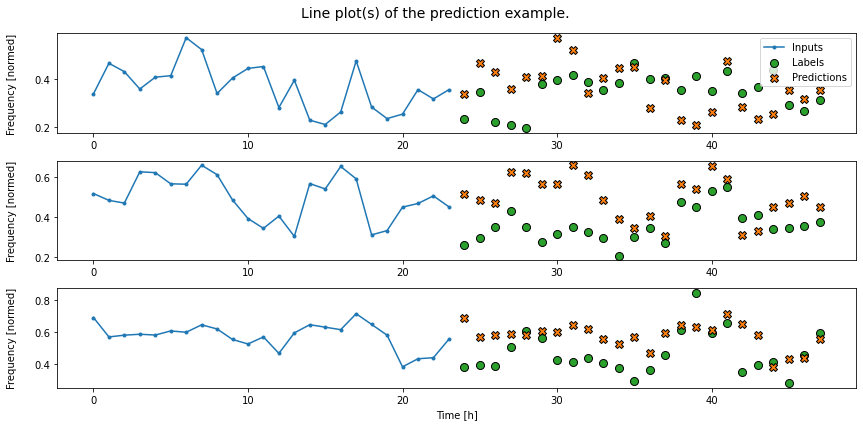

In [27]:
column_indices = {name: i for i, name in enumerate(df_temp.columns)}
model = Baseline(label_index=column_indices['Frequency'])
#model = RepeatBaseline()
model_train = trainModel(model, step_window)
model = model_train.train()
IPython.display.clear_output()
model_train.plot(3)

comp_val_score['baseline'], comp_test_score['baseline'] = model_train.metric()
display(model.summary())

#### 2. Linear

54/54 [==============================] - 0s 1ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - r_squared: -20.6120
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24, 24)            48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


None

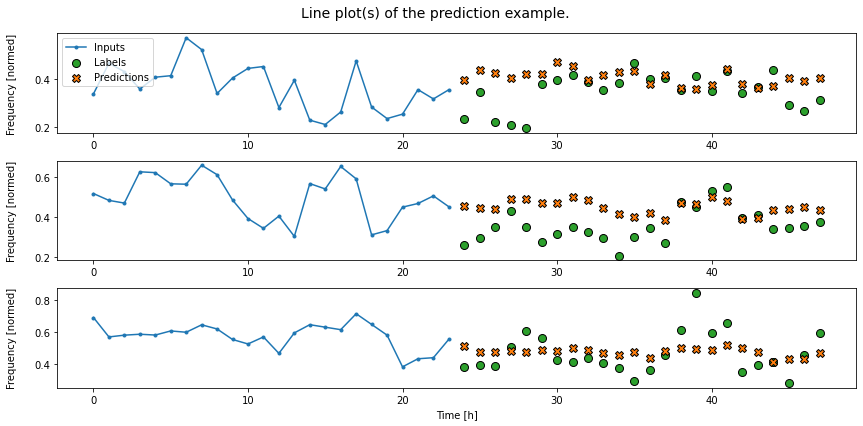

In [28]:
# Model config
output_unit = label_width

# Compile config
learning_rate = 0.01

model = linear(output_unit)
model_train = trainModel(model, step_window)
model = model_train.train(learning_rate=learning_rate)
IPython.display.clear_output()
model_train.plot(3)

comp_val_score['linear'], comp_test_score['linear'] = model_train.metric()
display(model.summary())

#### 3. LSTM

54/54 [==============================] - 0s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241 - r_squared: 0.0681
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            4352      
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 24)                18456     
_________________________________________________________________
reshape (Reshape)            (None, 24, 1)             0         
Total params: 22,808
Trainable params: 22,808
Non-trainable params: 0
_________________________________________________________________


None

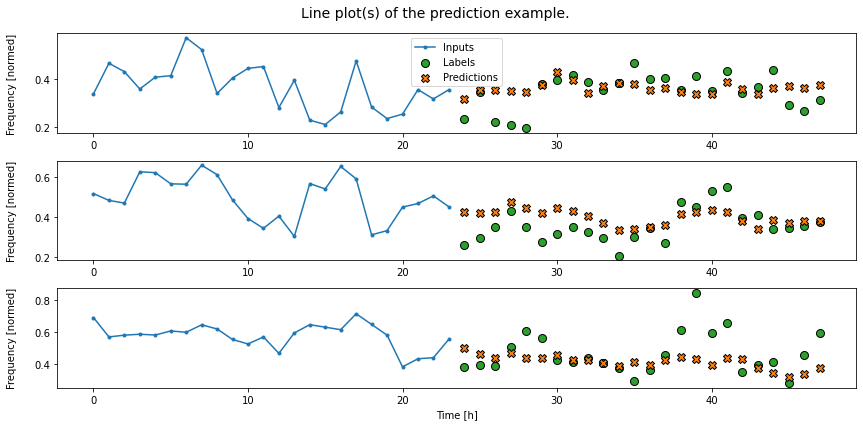

In [29]:
# lstm model config
lstm_unit = 32
output_unit = label_width

# Compile config
learning_rate=0.01

model = lstm(lstm_unit, output_unit)
model_train = trainModel(model, step_window)
model = model_train.train(learning_rate=learning_rate)
IPython.display.clear_output()
model_train.plot(3)

comp_val_score['lstm'], comp_test_score['lstm'] = model_train.metric()
display(model.summary())

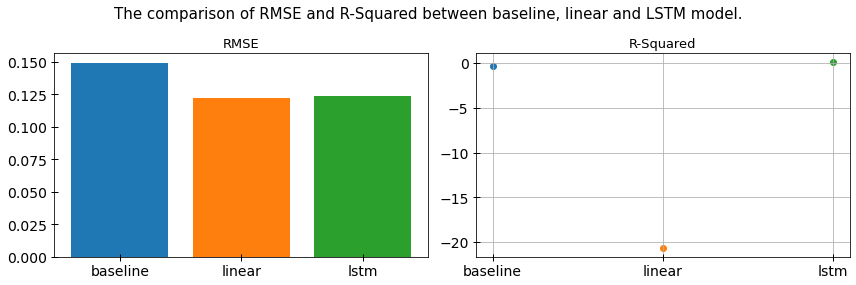

In [30]:
fig, axe = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f"The comparison of RMSE and R-Squared between baseline, "
             f"linear and LSTM model.", size=15)
for val_score_key, val_score_value in comp_val_score.items():
    axe[0].bar(x=val_score_key, height=val_score_value[1])
    axe[1].scatter(x=val_score_key, y=val_score_value[2])
    axe[1].grid()

for i in range(2):
    axe[i].tick_params(axis='x', width=1, length=7, 
                       direction='inout', rotation=0, labelsize=14)
    axe[i].tick_params(axis='y', width=1, length=7, 
                       direction='inout', rotation=0, labelsize=14)

axe[0].set_title("RMSE", size=13)
axe[1].set_title("R-Squared", size=13)
plt.tight_layout()
plt.show()

As you can see in the figure, both linear and LSTM model work better in forecasting the frequency than baseline model because they have lower RMSE value. However, if we look at R-Squared, the linear model has significantly negative value. This means that the linear model is worse than fitting a horizontal line to the data. In conclusion, LSTM model having a low RMSE and positive R-Squared is the most suitable model to predict time-series data of the frequency in the power grid.

### 2. Comparison between specified size of input to predict the frequency with 8 steps ahead

In [31]:
comp_input_score = {}

#### 2.1 Training LSTM model which input is 1 hours to predict next hours from 1 to 8 hour.

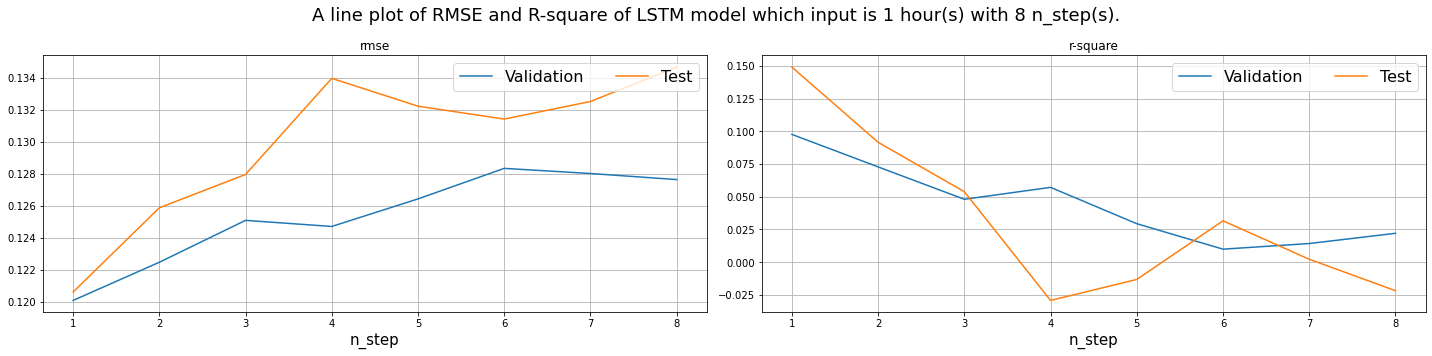

In [32]:
# lstm model config
lstm_unit = 32

# Compile config
learning_rate=0.01

# Step window config
input_width = 1
max_n_step = 8

model_list = []
score = []

for n_step in range(1,max_n_step+1):
    print(f'n_step: {n_step}')
    
    step_window = WindowGenerator(
            input_width=input_width, label_width=n_step, shift=n_step,
            train_df=df_train, val_df=df_val, test_df=df_test,
            label_columns=['Frequency'])
    display(step_window)

    model = lstm(lstm_unit, n_step)
    model_train = trainModel(model, step_window)
    model = model_train.train(learning_rate=learning_rate)
    model_list.append(model)
    #IPython.display.clear_output()
    display(model.summary())
    model_train.plot(3)
    score.append(model_train.metric())
    plt.show()
    print("")
comp_input_score[input_width] = score
IPython.display.clear_output()
fig, axe = performance(score, model).plot()
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=18)
plt.tight_layout()
plt.show()

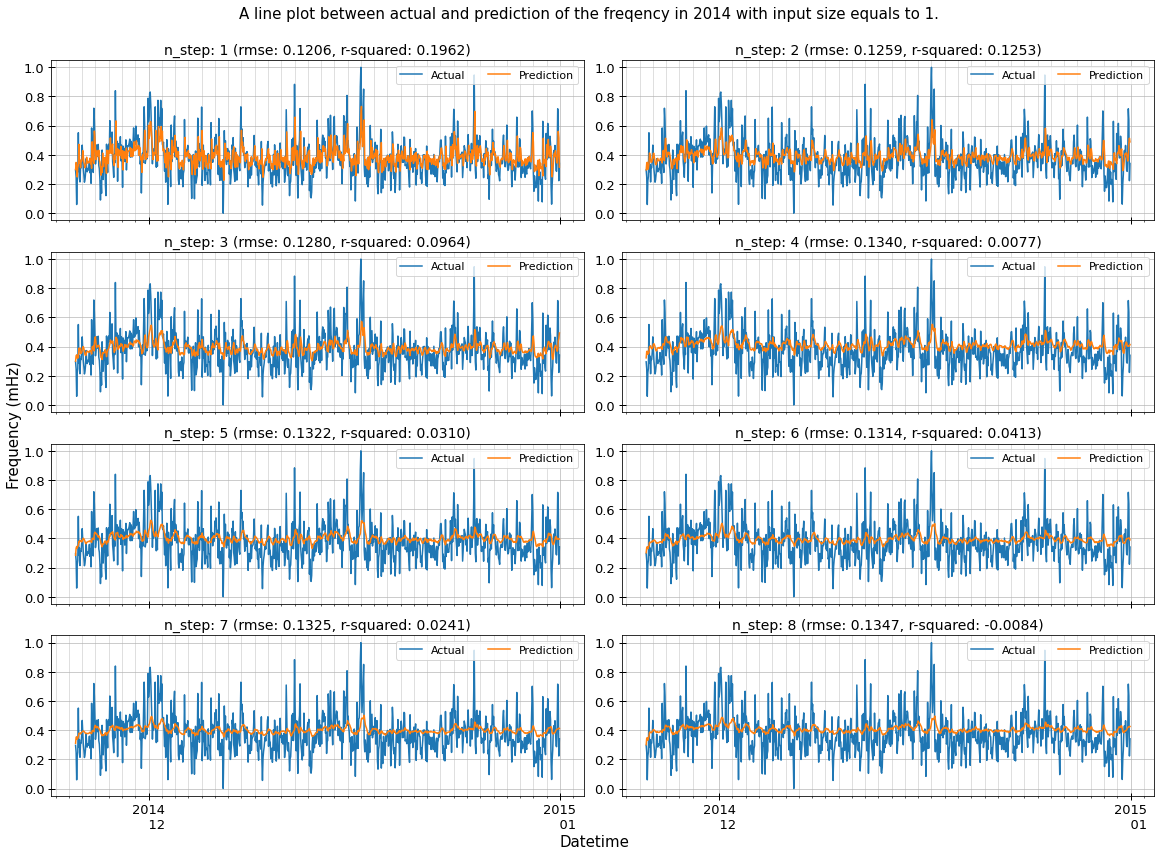

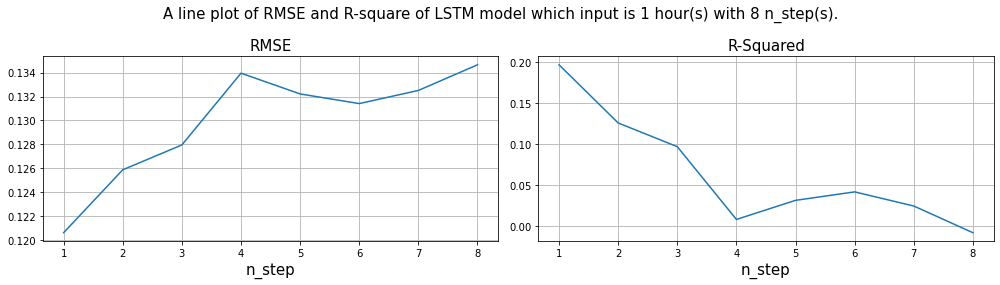

In [33]:
n_step_list = range(1,max_n_step+1)
col_num = 2
row_num = int(max_n_step/col_num)
n_step_list = np.array(n_step_list).reshape(row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, 
                        figsize=(8*col_num, 2.9*row_num), sharex=True)
fig.suptitle(f"A line plot between actual and prediction of the freqency "
             f"in 2014 with input size equals to {input_width}.", y=1, size=15)
fig.text(0.505, -0.005, 'Datetime', ha='center', fontsize=15)
fig.text(-0.005, 0.500, 'Frequency (mHz)', va='center', rotation='vertical', fontsize=15)
score = []
for i, rows in enumerate(n_step_list):
    for j, n_step in enumerate(rows):
        lstm_predict = predictModel(df_test)
        lstm_predict.preprocessing([['Frequency', -55, 55]])
        lstm_predict.split_sequence(input_width, n_step)
        lstm_predict.predict(model_list)
        rmse, r2score = lstm_predict.metric()
        lstm_predict.plot(axe[i][j], ylabel="", legendsize=11, showmetric=False)
        axe[i][j].set_title(f"n_step: {n_step} "
                            f"(rmse: {rmse:0.4f}, "
                            f"r-squared: {r2score:0.4f})", size=14)
        score.append(lstm_predict.metric())
plt.tight_layout()
plt.show()

# Store the score for comparison
comp_input_score[input_width] = score

fig, axe = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) "
             f"with {max_n_step} n_step(s).", size=15)
axe = lstm_predict.metric_plot(score, axe)
plt.tight_layout()
plt.show()

#### 2.2 Training LSTM model which input is 2 hours to predict next hours from 1 to 8 hour.

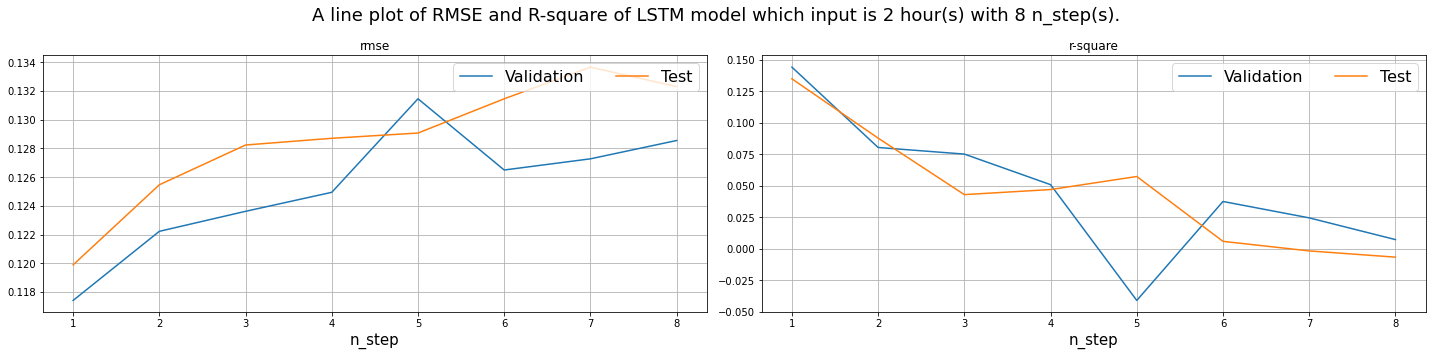

In [34]:
# lstm model config
lstm_unit = 32

# Compile config
learning_rate = 0.01

# Step window config
input_width = 2
max_n_step = 8

model_list = []
score = []

for n_step in range(1,max_n_step+1):
    print(f'n_step: {n_step}')
    
    step_window = WindowGenerator(
            input_width=input_width, label_width=n_step, shift=n_step,
            train_df=df_train, val_df=df_val, test_df=df_test,
            label_columns=['Frequency'])
    display(step_window)

    model = lstm(lstm_unit, n_step)
    model_train = trainModel(model, step_window)
    model = model_train.train(learning_rate=learning_rate)
    model_list.append(model)
    #IPython.display.clear_output()
    display(model.summary())
    model_train.plot(3)
    score.append(model_train.metric())
    plt.show()
    print("")
IPython.display.clear_output()
fig, axe = performance(score, model).plot()
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=18)
plt.show()

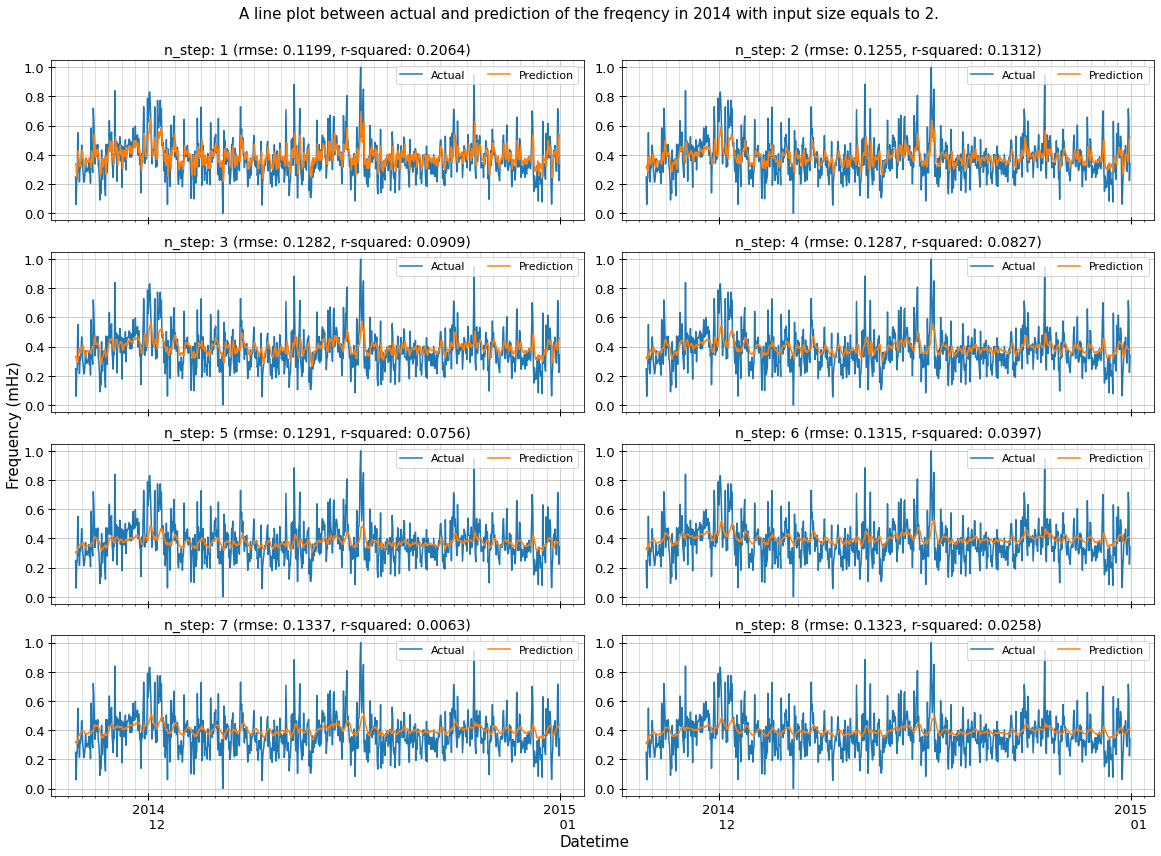

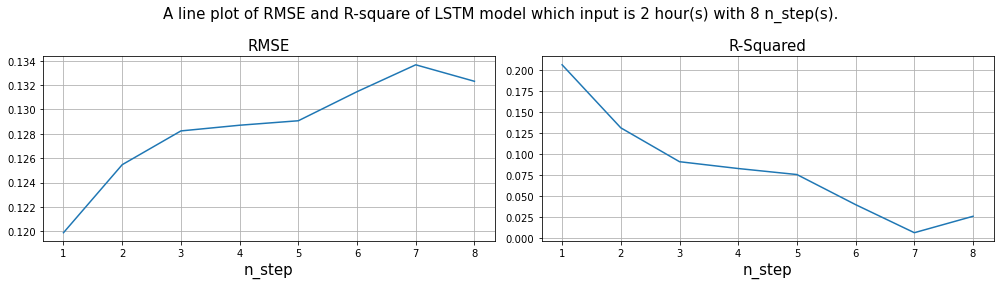

In [35]:
n_step_list = range(1,max_n_step+1)
col_num = 2
row_num = int(max_n_step/col_num)
n_step_list = np.array(n_step_list).reshape(row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, 
                        figsize=(8*col_num, 2.9*row_num), sharex=True)
fig.suptitle(f"A line plot between actual and prediction of the freqency "
             f"in 2014 with input size equals to {input_width}.", y=1, size=15)
fig.text(0.505, -0.005, 'Datetime', ha='center', fontsize=15)
fig.text(-0.005, 0.500, 'Frequency (mHz)', va='center', rotation='vertical', fontsize=15)
score = []
for i, rows in enumerate(n_step_list):
    for j, n_step in enumerate(rows):
        lstm_predict = predictModel(df_test)
        lstm_predict.preprocessing([['Frequency', -55, 55]])
        lstm_predict.split_sequence(input_width, n_step)
        lstm_predict.predict(model_list)
        rmse, r2score = lstm_predict.metric()
        lstm_predict.plot(axe[i][j], ylabel="", legendsize=11, showmetric=False)
        axe[i][j].set_title(f"n_step: {n_step} "
                            f"(rmse: {rmse:0.4f}, "
                            f"r-squared: {r2score:0.4f})", size=14)
        score.append(lstm_predict.metric())
plt.tight_layout()
plt.show()

# Store the score for comparison
comp_input_score[input_width] = score

fig, axe = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) "
             f"with {max_n_step} n_step(s).", size=15)
axe = lstm_predict.metric_plot(score, axe)
plt.tight_layout()
plt.show()

#### 2.3 Training LSTM model which input is 4 hours to predict next hours from 1 to 8 hour.

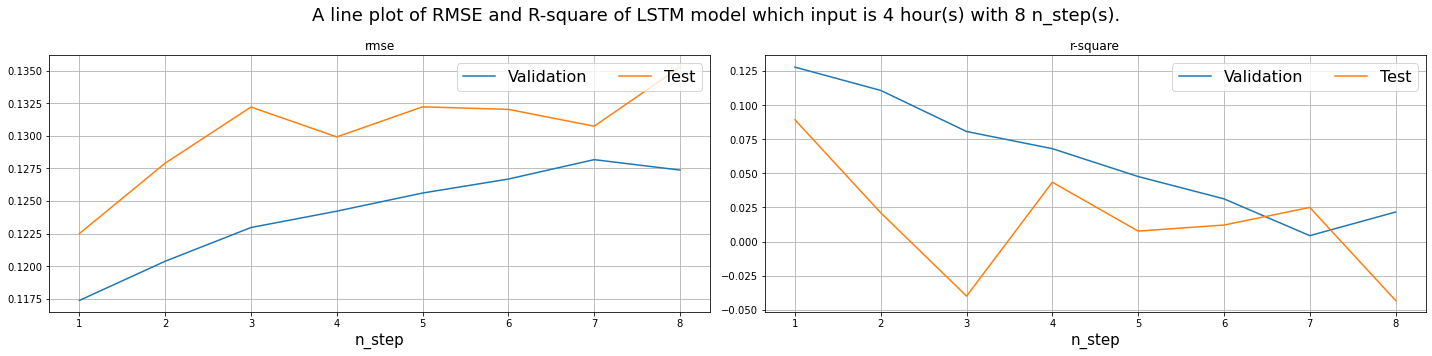

In [36]:
# lstm model config
lstm_unit = 32

# Compile config
learning_rate=0.01

# Step window config
input_width = 4
max_n_step = 8

model_list = []
score = []

for n_step in range(1,max_n_step+1):
    print(f'n_step: {n_step}')
    
    step_window = WindowGenerator(
            input_width=input_width, label_width=n_step, shift=n_step,
            train_df=df_train, val_df=df_val, test_df=df_test,
            label_columns=['Frequency'])
    display(step_window)

    model = lstm(lstm_unit, n_step)
    model_train = trainModel(model, step_window)
    model = model_train.train(learning_rate=learning_rate)
    model_list.append(model)
    #IPython.display.clear_output()
    display(model.summary())
    model_train.plot(3)
    score.append(model_train.metric())
    plt.show()
    print("")
IPython.display.clear_output()
fig, axe = performance(score, model).plot()
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=18)
plt.tight_layout()
plt.show()

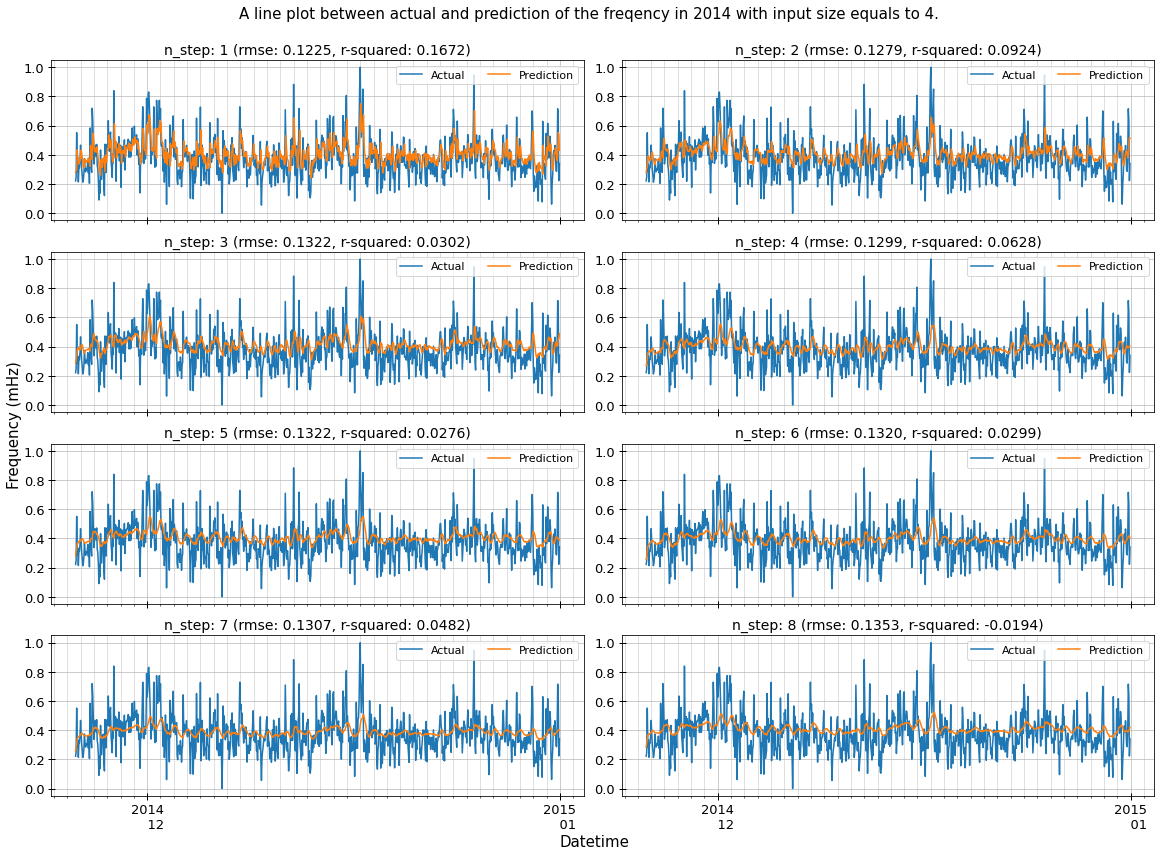

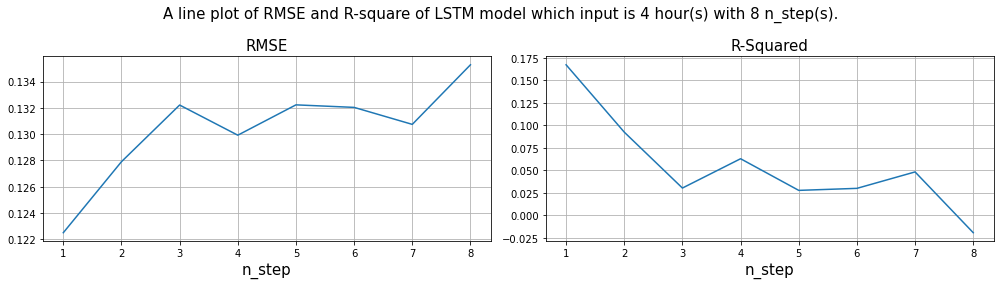

In [37]:
n_step_list = range(1,max_n_step+1)
col_num = 2
row_num = int(max_n_step/col_num)
n_step_list = np.array(n_step_list).reshape(row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, 
                        figsize=(8*col_num, 2.9*row_num), sharex=True)
fig.suptitle(f"A line plot between actual and prediction of the freqency "
             f"in 2014 with input size equals to {input_width}.", y=1, size=15)
fig.text(0.505, -0.005, 'Datetime', ha='center', fontsize=15)
fig.text(-0.005, 0.500, 'Frequency (mHz)', va='center', rotation='vertical', fontsize=15)
score = []
for i, rows in enumerate(n_step_list):
    for j, n_step in enumerate(rows):
        lstm_predict = predictModel(df_test)
        lstm_predict.preprocessing([['Frequency', -55, 55]])
        lstm_predict.split_sequence(input_width, n_step)
        lstm_predict.predict(model_list)
        rmse, r2score = lstm_predict.metric()
        lstm_predict.plot(axe[i][j], ylabel="", legendsize=11, showmetric=False)
        axe[i][j].set_title(f"n_step: {n_step} "
                            f"(rmse: {rmse:0.4f}, "
                            f"r-squared: {r2score:0.4f})", size=14)
        score.append(lstm_predict.metric())
plt.tight_layout()
plt.show()

# Store the score for comparison
comp_input_score[input_width] = score

fig, axe = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) "
             f"with {max_n_step} n_step(s).", size=15)
axe = lstm_predict.metric_plot(score, axe)
plt.tight_layout()
plt.show()

#### 2.4 Training LSTM model which input is 8 hours to predict next hours from 1 to 8 hour.

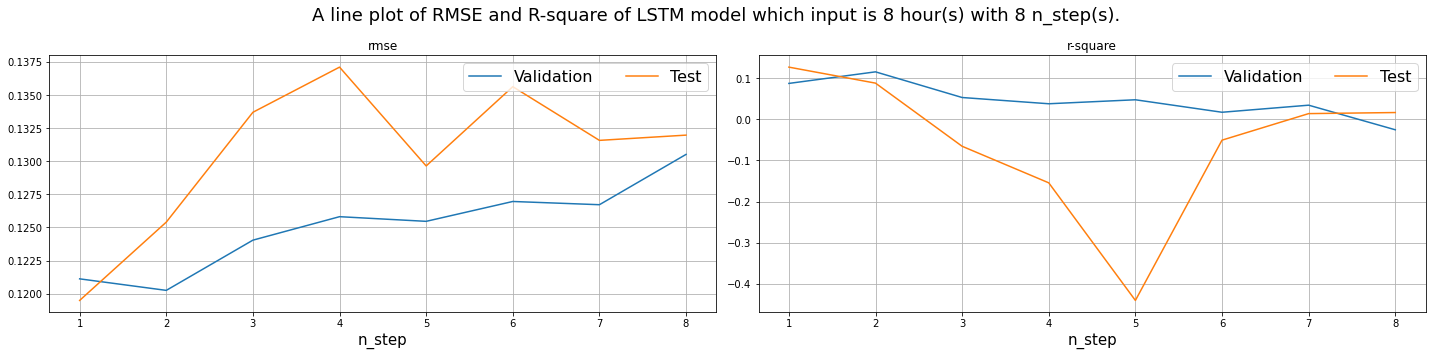

In [38]:
# lstm model config
lstm_unit = 32

# Compile config
learning_rate=0.01

# Step window config
input_width = 8
max_n_step = 8

model_list = []
score = []

for n_step in range(1,max_n_step+1):
    print(f'n_step: {n_step}')
    
    step_window = WindowGenerator(
            input_width=input_width, label_width=n_step, shift=n_step,
            train_df=df_train, val_df=df_val, test_df=df_test,
            label_columns=['Frequency'])
    display(step_window)

    model = lstm(lstm_unit, n_step)
    model_train = trainModel(model, step_window)
    model = model_train.train(learning_rate=learning_rate)
    model_list.append(model)
    #IPython.display.clear_output()
    display(model.summary())
    model_train.plot(3)
    score.append(model_train.metric())
    plt.show()
    print("")
comp_input_score[input_width] = score
IPython.display.clear_output()
fig, axe = performance(score, model).plot()
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=18)
plt.tight_layout()
plt.show()

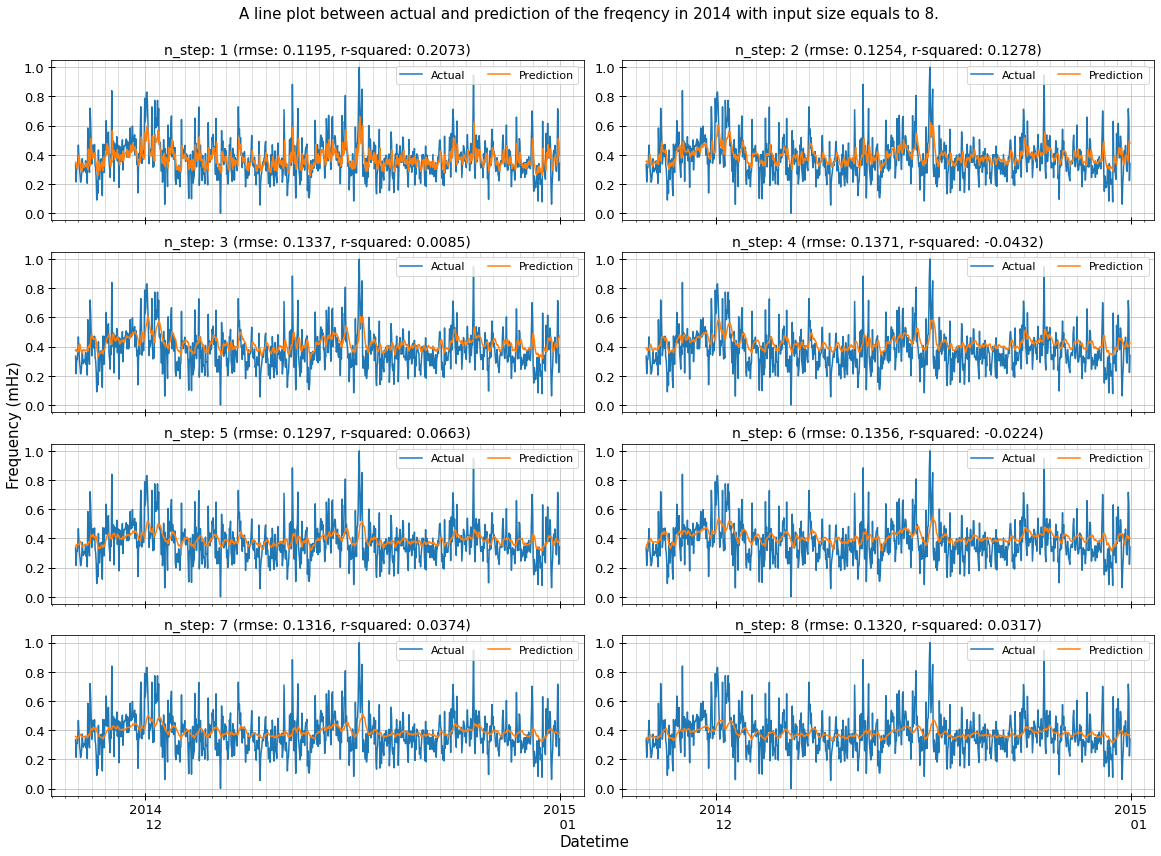

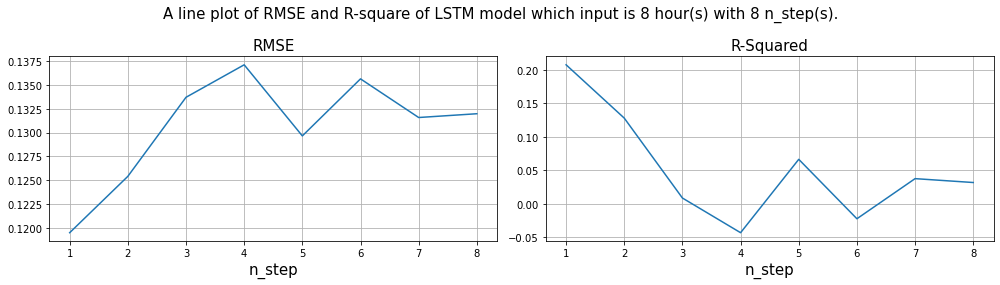

In [39]:
n_step_list = range(1,max_n_step+1)
col_num = 2
row_num = int(max_n_step/col_num)
n_step_list = np.array(n_step_list).reshape(row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, 
                        figsize=(8*col_num, 2.9*row_num), sharex=True)
fig.suptitle(f"A line plot between actual and prediction of the freqency "
             f"in 2014 with input size equals to {input_width}.", y=1, size=15)
fig.text(0.505, -0.005, 'Datetime', ha='center', fontsize=15)
fig.text(-0.005, 0.500, 'Frequency (mHz)', va='center', rotation='vertical', fontsize=15)
score = []
for i, rows in enumerate(n_step_list):
    for j, n_step in enumerate(rows):
        lstm_predict = predictModel(df_test)
        lstm_predict.preprocessing([['Frequency', -55, 55]])
        lstm_predict.split_sequence(input_width, n_step)
        lstm_predict.predict(model_list)
        rmse, r2score = lstm_predict.metric()
        lstm_predict.plot(axe[i][j], ylabel="", legendsize=11, showmetric=False)
        axe[i][j].set_title(f"n_step: {n_step} "
                            f"(rmse: {rmse:0.4f}, "
                            f"r-squared: {r2score:0.4f})", size=14)
        score.append(lstm_predict.metric())
plt.tight_layout()
plt.show()

# Store the score for comparison
comp_input_score[input_width] = score

fig, axe = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) "
             f"with {max_n_step} n_step(s).", size=15)
axe = lstm_predict.metric_plot(score, axe)
plt.tight_layout()
plt.show()

#### 2.5 The result of comparison between each input.

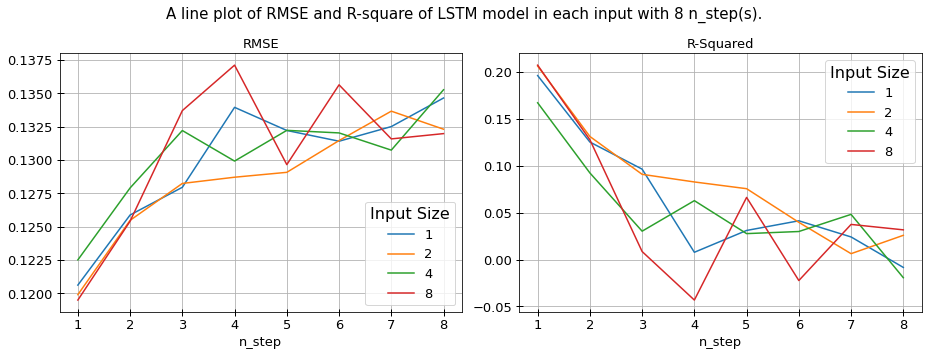

In [52]:
lstm_predict = predictModel(df_test)
fig, axe = plt.subplots(1, 2, figsize=(13,5))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"in each input with {max_n_step} n_step(s).", size=15)
for key, scores in comp_input_score.items():
    axe = lstm_predict.metric_plot(scores, axe, comp_input_score.keys())
axe[0].grid()
axe[1].grid()
plt.tight_layout()
plt.show()

### 3. Prediction of the frequency with input size is 3 to predict output with n steps.

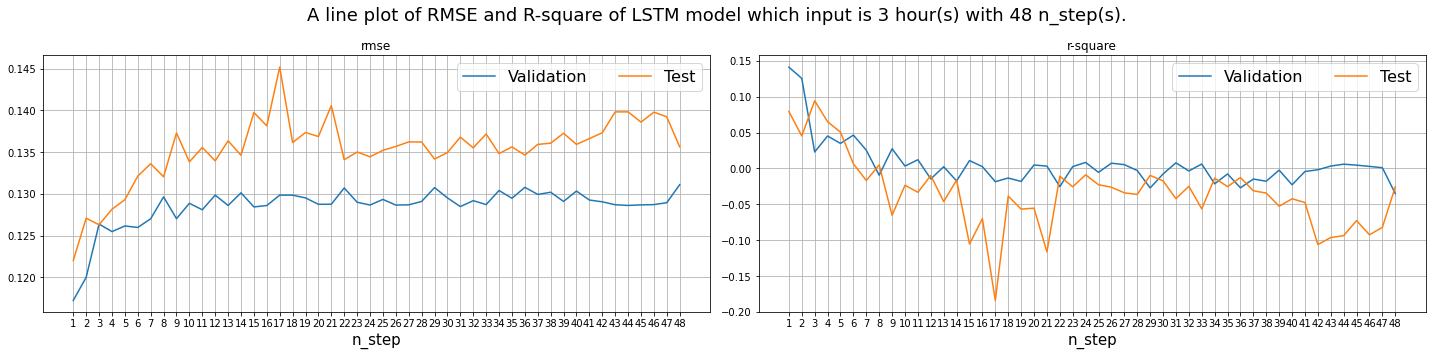

In [53]:
# lstm model config
lstm_unit = 32

# Compile config
learning_rate=0.01

# Step window config
input_width = 3
max_n_step = 48

model_list = []
score = []

for n_step in range(1,max_n_step+1):
    print(f'n_step: {n_step}')
    
    step_window = WindowGenerator(
            input_width=input_width, label_width=n_step, shift=n_step,
            train_df=df_train, val_df=df_val, test_df=df_test,
            label_columns=['Frequency'])
    display(step_window)

    model = lstm(lstm_unit, n_step)
    model_train = trainModel(model, step_window)
    model = model_train.train(learning_rate=learning_rate)
    model_list.append(model)
    #IPython.display.clear_output()
    display(model.summary())
    model_train.plot(3)
    score.append(model_train.metric())
    plt.show()
    print("")

IPython.display.clear_output()
fig, axe = performance(score, model).plot(n_step_interval=5)
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=18)

plt.tight_layout()
plt.show()

In [95]:

importlib.reload(prediction)
from prediction import trainModel, performance, predictModel, r_squared

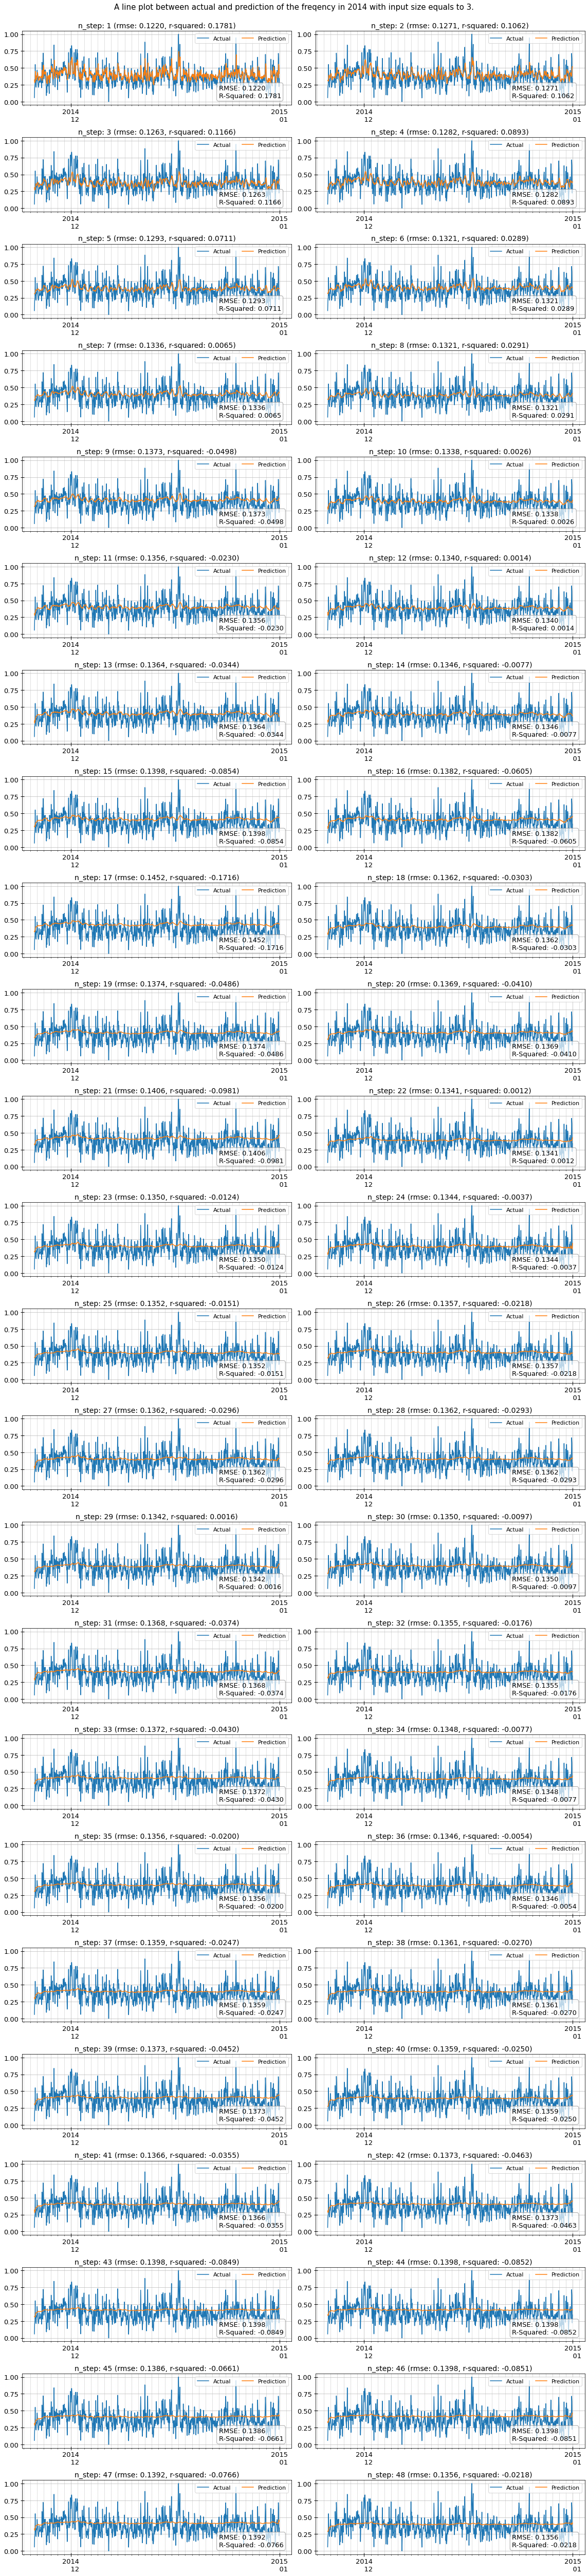

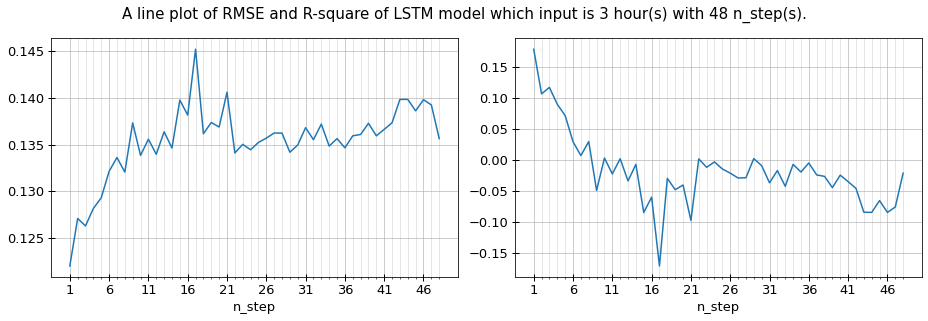

In [107]:
n_step_list = range(1,max_n_step+1)
col_num = 2
row_num = int(max_n_step/col_num)
n_step_list = np.array(n_step_list).reshape(row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, figsize=(8*col_num, 2.9*row_num))
fig.suptitle(f"A line plot between actual and prediction of the freqency "
             f"in 2014 with input size equals to {input_width}.", y=1, size=15)
score = []
for i, rows in enumerate(n_step_list):
    for j, n_step in enumerate(rows):
        lstm_predict = predictModel(df_test)
        lstm_predict.preprocessing([['Frequency', -55, 55]])
        lstm_predict.split_sequence(input_width, n_step)
        lstm_predict.predict(model_list)
        rmse, r2score = lstm_predict.metric()
        lstm_predict.plot(axe[i][j], ylabel="", legendsize=11, showmetric=True)
        axe[i][j].set_title(f"n_step: {n_step} "
                            f"(rmse: {rmse:0.4f}, "
                            f"r-squared: {r2score:0.4f})", size=14)
        score.append(lstm_predict.metric())
plt.tight_layout()
plt.show()

# Store the score for comparison
comp_input_score[input_width] = score

fig, axe = plt.subplots(1, 2, figsize=(13,4.5))
fig.suptitle(f"A line plot of RMSE and R-square of LSTM model "
             f"which input is {input_width} hour(s) with {max_n_step} n_step(s).", size=15)
axe = lstm_predict.metric_plot(score, axe, 5)
plt.tight_layout()
plt.show()

### 4. Predict and plot the test dataset in year 2014

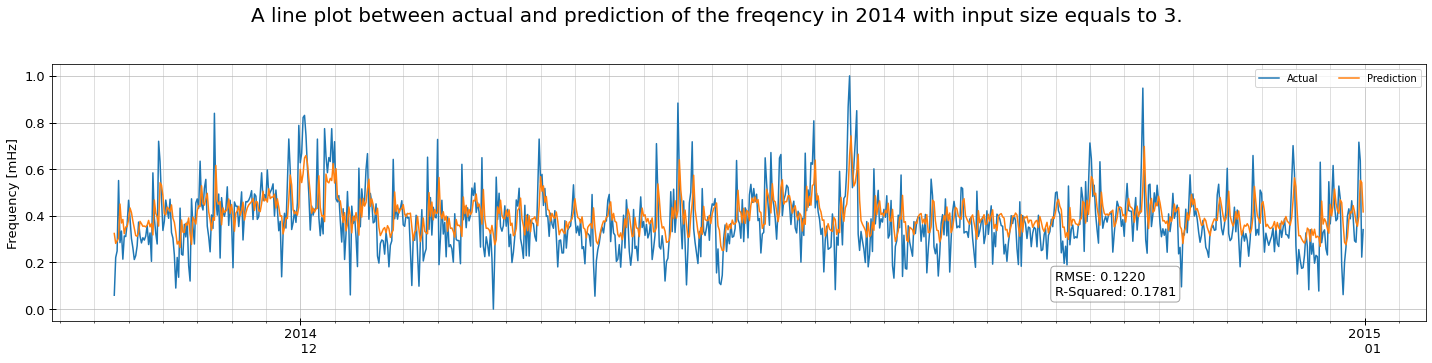

In [104]:
# Split sequence config
input_width = 3
shift = 1

fig, axe = plt.subplots(figsize=(20,5))
fig.suptitle(f'A line plot between actual and prediction of the freqency in 2014 with input size equals to {input_width}.', y=1, size=20)
#lstm_predict = predictModel(df_freqs[2014])
lstm_predict = predictModel(df_test)
lstm_predict.preprocessing([['Frequency', -55, 55]])
lstm_predict.split_sequence(input_width, shift)
lstm_predict.predict(model_list)
lstm_predict.plot(axe)
plt.tight_layout()
plt.show()

### 5. Predict and plot the frequency in each year

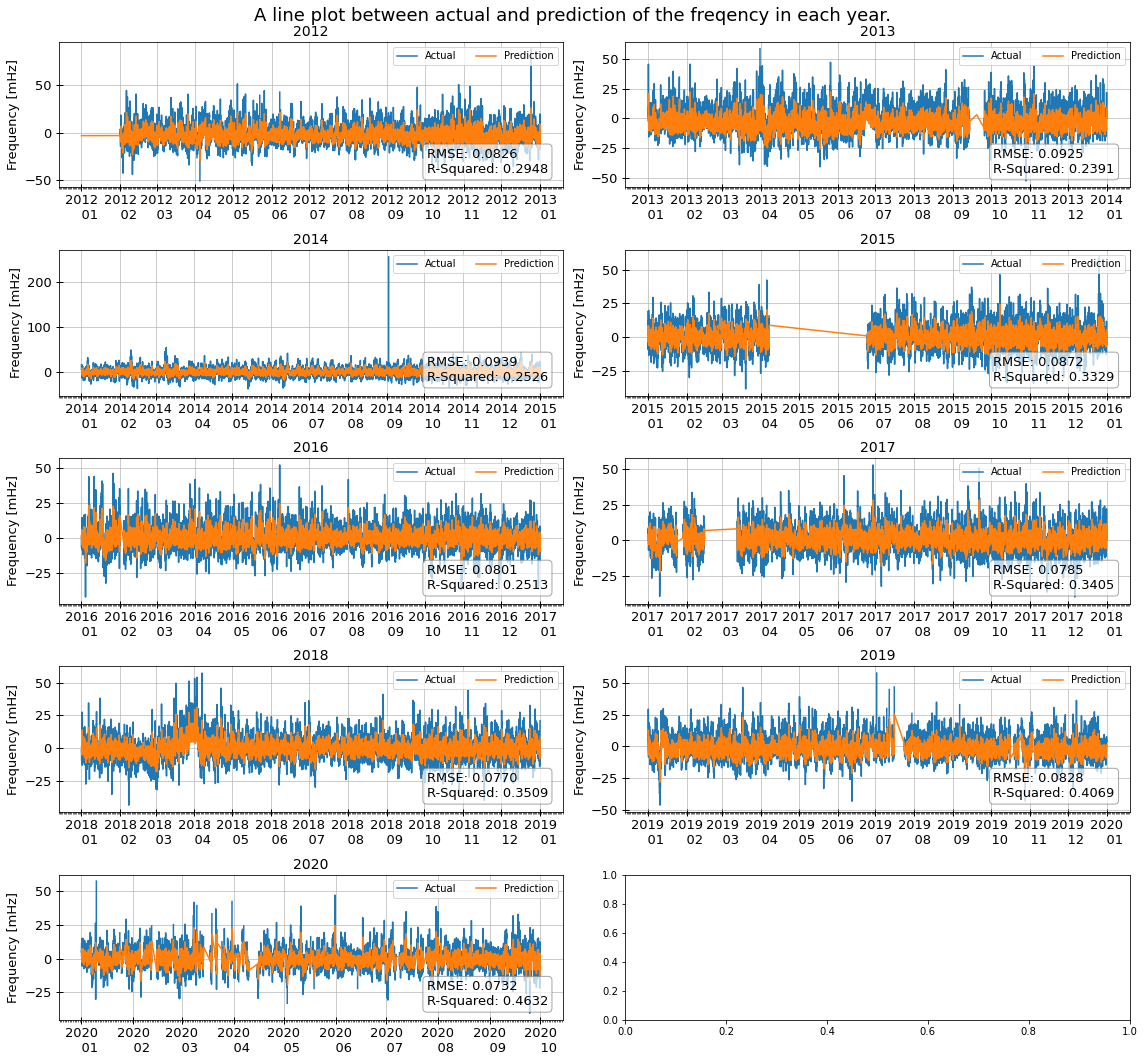

In [106]:
years = range(2012, 2022)
col_num = 2
row_num = int(len(years)/col_num)
years = np.array(years).reshape(row_num, col_num)

# Split sequence config
input_width = 3
shift = 1

fig, axe = plt.subplots(row_num, col_num, figsize=(8*col_num, 3*row_num))
fig.suptitle(f'A line plot between actual and prediction '
             f'of the freqency in each year.', size=18)

try:
    for i, rows in enumerate(years):
        for j, year in enumerate(rows):
            lstm_predict = predictModel(df_freqs[year])
            lstm_predict.preprocessing([['Frequency', -55, 55]])
            lstm_predict.split_sequence(input_width, shift)
            lstm_predict.predict(model_list)
            lstm_predict.plot(axe[i][j], ylabel="Frequency [mHz]", title=year)
            axe[i][j].grid(visible=True, which='major', axis='x', alpha=0.8)
            axe[i][j].grid(visible=False, which='minor', axis='x', alpha=0.5)
            axe[i][j].grid(visible=True, which='major', axis='y', alpha=0.8)
except:
    pass

plt.tight_layout()
plt.show()